In [12]:
#import
#
#import
import json
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
import datetime
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import scipy as sp
from scipy import stats
from scipy.stats import ttest_ind_from_stats
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import statsmodels.api as sm
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import f_regression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics.scorer import make_scorer
from sklearn.tree import DecisionTreeClassifier
import sklearn.linear_model
import sklearn.svm
from sklearn.ensemble import GradientBoostingClassifier #For Classification
from sklearn.ensemble import AdaBoostClassifier
from sklearn.grid_search import GridSearchCV
#from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix
import scipy.stats as sp
from sklearn import svm
from sklearn.model_selection import cross_val_score
from scipy.stats.stats import pearsonr


/home/shady/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/shady/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [ ]:
#download data
#download data
symbol = 'EUR=X'
y = 10

x=datetime.datetime.now().year
currency = pd.DataFrame()
for i in range(y):
    n = x-i
    startDate = '%d-01-01' % n
    endDate = '%d-12-31' %n
    url = 'https://query.yahooapis.com/v1/public/yql?q=select * from yahoo.finance.historicaldata where symbol = "%s" and startDate = "%s" and endDate = "%s"&format=json&diagnostics=true&env=store://datatables.org/alltableswithkeys&callback=' % (symbol,startDate,endDate)
    req = requests.get(url)
    req=req.json()
    j = [j for j in req['query']['results']['quote'] ]
    currency = currency.append(pd.DataFrame(j), ignore_index=True)
    
n = ['Date','Open','Close','High','Low']
currency = currency[n]
currency['Pips']=round((pd.to_numeric(currency.Open)-pd.to_numeric(currency.Close))*100000)


currency=currency.reindex(index=currency.index[::-1])
currency=currency.reset_index(drop= True)
     
 

In [ ]:
##calculate quantile for pips sizez
ind1 = 0
ind2 = 1860

p = currency.Pips[ind1:ind2]

q=[]
for i in range(len(p)):
    if p[i] <= p.quantile(0.125):
        q.append(1)
    elif p[i] <= p.quantile(0.25):
        q.append(2)
    elif p[i] <= p.quantile(0.375):
        q.append(3)
    elif p[i] <= p.quantile(0.5):
        q.append(4)
    elif p[i] <= p.quantile(0.625):
        q.append(5)
    elif p[i] <= p.quantile(0.75):
        q.append(6)
    elif p[i] <= p.quantile(0.875):
        q.append(7)
    else:
        q.append(8)

ind1 = 1860
ind2 = len(currency) 
p = currency.Pips[ind1:ind2]  
p=p.reset_index(drop=True)
for i in range(len(p)):
    if p[i] <= p.quantile(0.125):
        q.append(1)
    elif p[i] <= p.quantile(0.25):
        q.append(2)
    elif p[i] <= p.quantile(0.375):
        q.append(3)
    elif p[i] <= p.quantile(0.5):
        q.append(4)
    elif p[i] <= p.quantile(0.625):
        q.append(5)
    elif p[i] <= p.quantile(0.75):
        q.append(6)
    elif p[i] <= p.quantile(0.875):
        q.append(7)
    else:
        q.append(8)
        
currency2 = currency
currency2['q']=q

In [ ]:
#divide testing & training data

Xtrain = currency2[0:1860]
Ytrain = currency2[0:1860].Pips>0

Xtest = currency2[1860:len(currency2)]
Ytest = currency2[1860:len(currency2)].Pips>0

Xtest= Xtest.reset_index(drop = True)
Ytest= Ytest.reset_index(drop = True)

In [ ]:
#write data to csv to process them in another script in python2
Xtrain.to_csv('Xtrainfinal', sep='\t', index = False)
Xtest.to_csv('Xtestfinal', sep='\t', index = False)

In [80]:
#get data after processing
titrain= pd.read_csv("titrainfinal", sep = "\t")
titest= pd.read_csv("titestfinal", sep = "\t")

## Data Preprocessing pipeline
* get titrain
* join Xtrain-titrain
* calculate percentages 
* join PC
* shift
* prune rows

In [85]:
#join tables and shift observations
Xtrain = Xtrain.join(titrain)
Xtest = Xtest.join(titest)
Xtrain['d']=Xtrain.Pips<0
Xtest['d']=Xtest.Pips<0
Ytrain=Xtrain.d
Ytest=Xtest.d
YYtrain= []
YYtrain.append(np.nan)
for i in range(1, len(Xtrain)):
    if Xtrain.Close.values[i]<Xtrain.Close.values[i-1]:
        YYtrain.append(0)
    else:
        YYtrain.append(1)

        
YYtest=[]
YYtest.append(np.nan)
for i in range(1, len(Xtest)):
    if Xtest.Close.values[i]<Xtest.Close.values[i-1]:
        YYtest.append(0)
    else:
        YYtest.append(1)        





YYtrain= pd.Series(YYtrain)
YYtest= pd.Series(YYtest)


Xtrain['dccc']= YYtrain.values
Xtest['dccc']= YYtest.values


PC=pd.DataFrame()
#cols=[]
for i in Xtrain.columns:
    if i == 'Date':
        continue
    ti = i+'PC'
    
    col=[]
    col.append(np.nan)
    flag=0
    for j in range(1, len(Xtrain)):
        
        if not float(Xtrain[i][j-1]):
            tt=np.mean(pd.to_numeric(Xtrain[i]))
            col.append((float(Xtrain[i][j])-float(Xtrain[i][j-1]))/abs(tt))
            continue
            
        col.append((float(Xtrain[i][j])-float(Xtrain[i][j-1]))/abs(float(Xtrain[i][j-1])))
        
    PC[ti]=col
        
Xtrain = Xtrain.join(PC)
#print(cols)

PC=pd.DataFrame()
for i in Xtest.columns:
    if i == 'Date':
        continue
    ti = i+'PC'
    
    col=[]
    col.append(np.nan)
    flag=0
    for j in range(1, len(Xtest)):
        
        if not float(Xtest[i][j-1]):
            tt=np.mean(pd.to_numeric(Xtest[i]))
            col.append((float(Xtest[i][j])-float(Xtest[i][j-1]))/abs(tt))
            continue
            
        col.append((float(Xtest[i][j])-float(Xtest[i][j-1]))/abs(float(Xtest[i][j-1])))
        
    PC[ti]=col
        
Xtest = Xtest.join(PC)


cols = [i for i in Xtrain.columns if i not in ["Date","q","Pips"]]
Xtrain[cols] = Xtrain[cols].shift(1)


cols = [i for i in Xtest.columns if i not in ["Date","q","Pips"]]
Xtest[cols] = Xtest[cols].shift(1)

Xtrain = Xtrain.drop(["Date", "Pips", "q"], axis=1)
Xtest = Xtest.drop(["Date","Pips","q"], axis=1)


####

Xtrain=Xtrain.reset_index(drop=True)
Xtest=Xtest.reset_index(drop=True)
Ytrain=Ytrain.reset_index(drop=True)
Ytest=Ytest.reset_index(drop=True)

Xtrain=Xtrain.dropna()
Xtest=Xtest.dropna()

YYtrain=YYtrain[Xtrain.index]
YYtest=YYtest[Xtest.index]
Ytrain=Ytrain[Xtrain.index]
Ytest=Ytest[Xtest.index]


Xtrain=Xtrain.reset_index(drop=True)
Xtest=Xtest.reset_index(drop=True)
Ytrain=Ytrain.reset_index(drop=True)
Ytest=Ytest.reset_index(drop=True)
YYtest=YYtest.reset_index(drop=True)
YYtrain=YYtrain.reset_index(drop=True)

In [87]:
#Functions - mscore - changethr - fscorecols - treecols
def mscore(yactual, ypred):
    l=len(yactual)
    m = max(sum(yactual), l-sum(yactual))
    res1 = m/l
    err=0
    t=[int(i) for i in yactual]
    for i in range(l):
        tt = ypred[i]
        #t = yactual[i]
        if(tt!=t[i]):
        #if(2!=3):
            err=err+1
            
    err = 1- (err/l)
    #print(err)
    #print(res1)
    return err-res1

ms = make_scorer(mscore, greater_is_better=True)


def fscorecols(Xtrain, Ytrain):
    x,y=f_classif(Xtrain,Ytrain)
    return pd.concat([pd.DataFrame(np.round(x,5)),pd.DataFrame(np.round(y,5)), pd.DataFrame(Xtrain.columns)],axis=1,ignore_index=True).sort(ascending=True, columns=1).reset_index(drop=True)
    
    

def treecols(Xtrain, Ytrain, GB):
    importance_list = GB.feature_importances_
    name_list = Xtrain.columns
    importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
    return importance_list[::-1], name_list[::-1]
    

In [86]:
pd.concat([Xtrain.Open, Xtrain.Close,Xtrain.d, Xtrain.dccc, Xtrain.HighPC, Xtrain.High, Ytrain, YYtrain], axis=1,ignore_index=False)

,Open,Close,d,dccc,HighPC,High,d,0
0,0.64292,0.64679,True,1.0,0.004452,0.649790,True,1.0
1,0.64717,0.65066,True,1.0,0.004863,0.652950,False,0.0
2,0.64970,0.64625,False,0.0,-0.002466,0.651340,False,0.0
3,0.64625,0.64425,False,0.0,-0.007231,0.646630,False,0.0
4,0.64433,0.64358,False,0.0,-0.000278,0.646450,True,1.0
5,0.64354,0.64475,True,1.0,0.000000,0.646450,False,0.0
6,0.64475,0.63988,False,0.0,-0.001671,0.645370,True,1.0
7,0.64107,0.64421,True,1.0,0.001364,0.646250,False,0.0
8,0.64408,0.64226,False,0.0,-0.001485,0.645290,False,0.0
9,0.64225,0.63800,False,0.0,-0.002898,0.643420,False,0.0


In [88]:
pd.concat([currency[-10::].reset_index(drop=True), Xtest.Open[-10::].reset_index(drop=True),Xtest.Close[-10::].reset_index(drop=True),Xtest.d[-10::].reset_index(drop=True),Xtest.dccc[-10::].reset_index(drop=True),Ytest[-10::].reset_index(drop=True),YYtest[-10::].reset_index(drop=True),Xtest.HighPC[-10::].reset_index(drop=True),Xtest.High[-10::].reset_index(drop=True)], axis=1,ignore_index=False)

NameError: name 'currency' is not defined

In [285]:
#get best features
GB=GradientBoostingClassifier(n_estimators=10).fit(Xtrain, YYtrain)
#  select important features 
treenames_scores, treenames = treecols(GB=GB, Xtrain=Xtrain, Ytrain=YYtrain)
fnames = fscorecols(Xtrain=Xtrain, Ytrain=YYtrain)

/home/shady/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:25: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


In [288]:
sum(treenames_scores)

1.0

In [95]:
fnames[fnames[1]<=0.05]

,0,1,2
0,22.35516,0.00000,aroonup3PC
1,50.25311,0.00000,willr5
2,87.76551,0.00000,willr3
3,34.88604,0.00000,plusdi3
4,22.34691,0.00000,plusdi5
5,27.74682,0.00000,minusdm20PC
6,22.83503,0.00000,aroonup5PC
7,24.45939,0.00000,minusdm12PC
8,26.03855,0.00000,ultosc12
9,54.42827,0.00000,ultosc9


In [96]:
treenames

('ultosc3PC',
 'ultosc3',
 'HighPC',
 'OpenPC',
 'adxr5PC',
 'ultosc5',
 'cmo3PC',
 'macdhist12PC',
 'bop',
 'adxr20PC',
 'willr5PC',
 'macdsssignal9PC',
 'slowd20',
 'PipsPC',
 'ultosc5PC',
 'macdhhhist5PC',
 'ultosc12PC',
 'willr3',
 'adxr12PC',
 'slowd3PC',
 'minusdm3',
 'macdsssignal3PC',
 'LowPC',
 'slowd9',
 'adxr3PC',
 'fastkk20PC',
 'minusdm20',
 'minusdi3',
 'macdhhhist20PC',
 'adx20',
 'adx5PC',
 'slowd5PC',
 'macdsssignal20PC',
 'dx12',
 'ultosc20PC',
 'mprice20PC',
 'willr3PC',
 'macdhist5PC',
 'macdhhhist3PC',
 'slowd20PC',
 'macdhhhist9PC',
 'dx20PC',
 'macdssignal3PC',
 'httPC',
 'cci9',
 'adx5',
 'ppo12',
 'ultosc9',
 'trix3PC',
 'adx9',
 'minusdi3PC',
 'macdhhhist12',
 'macdhhist20PC',
 'macdhhhist12PC',
 'cci20',
 'ultosc9PC',
 'aroon5PC',
 'rocr10020PC',
 'slowk9PC',
 'sarextPC',
 'aroon20PC',
 'plusdi3PC',
 'willr12PC',
 'upperband9PC',
 'macdhhhist20',
 'mpoint20PC',
 'macdhist20PC',
 'rocp12PC',
 'fastk5PC',
 'aroon12PC',
 'slowd3',
 'cmo5PC',
 'macdssignal12PC',


In [1033]:
treenames_scores

(0.01507444762380143,
 0.011537438673393718,
 0.01082506130874486,
 0.010597310475885023,
 0.010311610366038084,
 0.0099917449637527949,
 0.0093233883584873615,
 0.0087677201579331922,
 0.008653618727962973,
 0.0085931818467695088,
 0.008278316779290527,
 0.0081821301835296682,
 0.0080709519822621031,
 0.0080097262597918946,
 0.0079654629900325225,
 0.0079131083692141925,
 0.0078999097606523867,
 0.0075705587146763179,
 0.0075562091989503713,
 0.0074583511356410247,
 0.0074366318854538526,
 0.0073281486018986763,
 0.0071614323824539024,
 0.0067333112671848069,
 0.0067121559409766872,
 0.0066832230441227197,
 0.0063543785818843419,
 0.0062895478198157313,
 0.0061983997043071276,
 0.0060414354659164109,
 0.0059439199099261793,
 0.0059165385201271226,
 0.0058410689240178063,
 0.005818091359109912,
 0.0057996583989016089,
 0.0057500540065479671,
 0.0056531449779166085,
 0.0054606078081142848,
 0.0054573686781015842,
 0.0054264587904502568,
 0.0052683675999717038,
 0.0052610921673160345,
 0

In [887]:
print(cross_val_score(cv=5, estimator=GB, X=Xtrain, y=YYtrain).mean())

0.65943747324


In [284]:
mscore(yactual=YYtest, ypred=GB.predict(Xtest))
GB.score(X=Xtrain, y=YYtrain)

0.7580275229357798

In [896]:
1-YYtest.mean()

0.46924829157175396

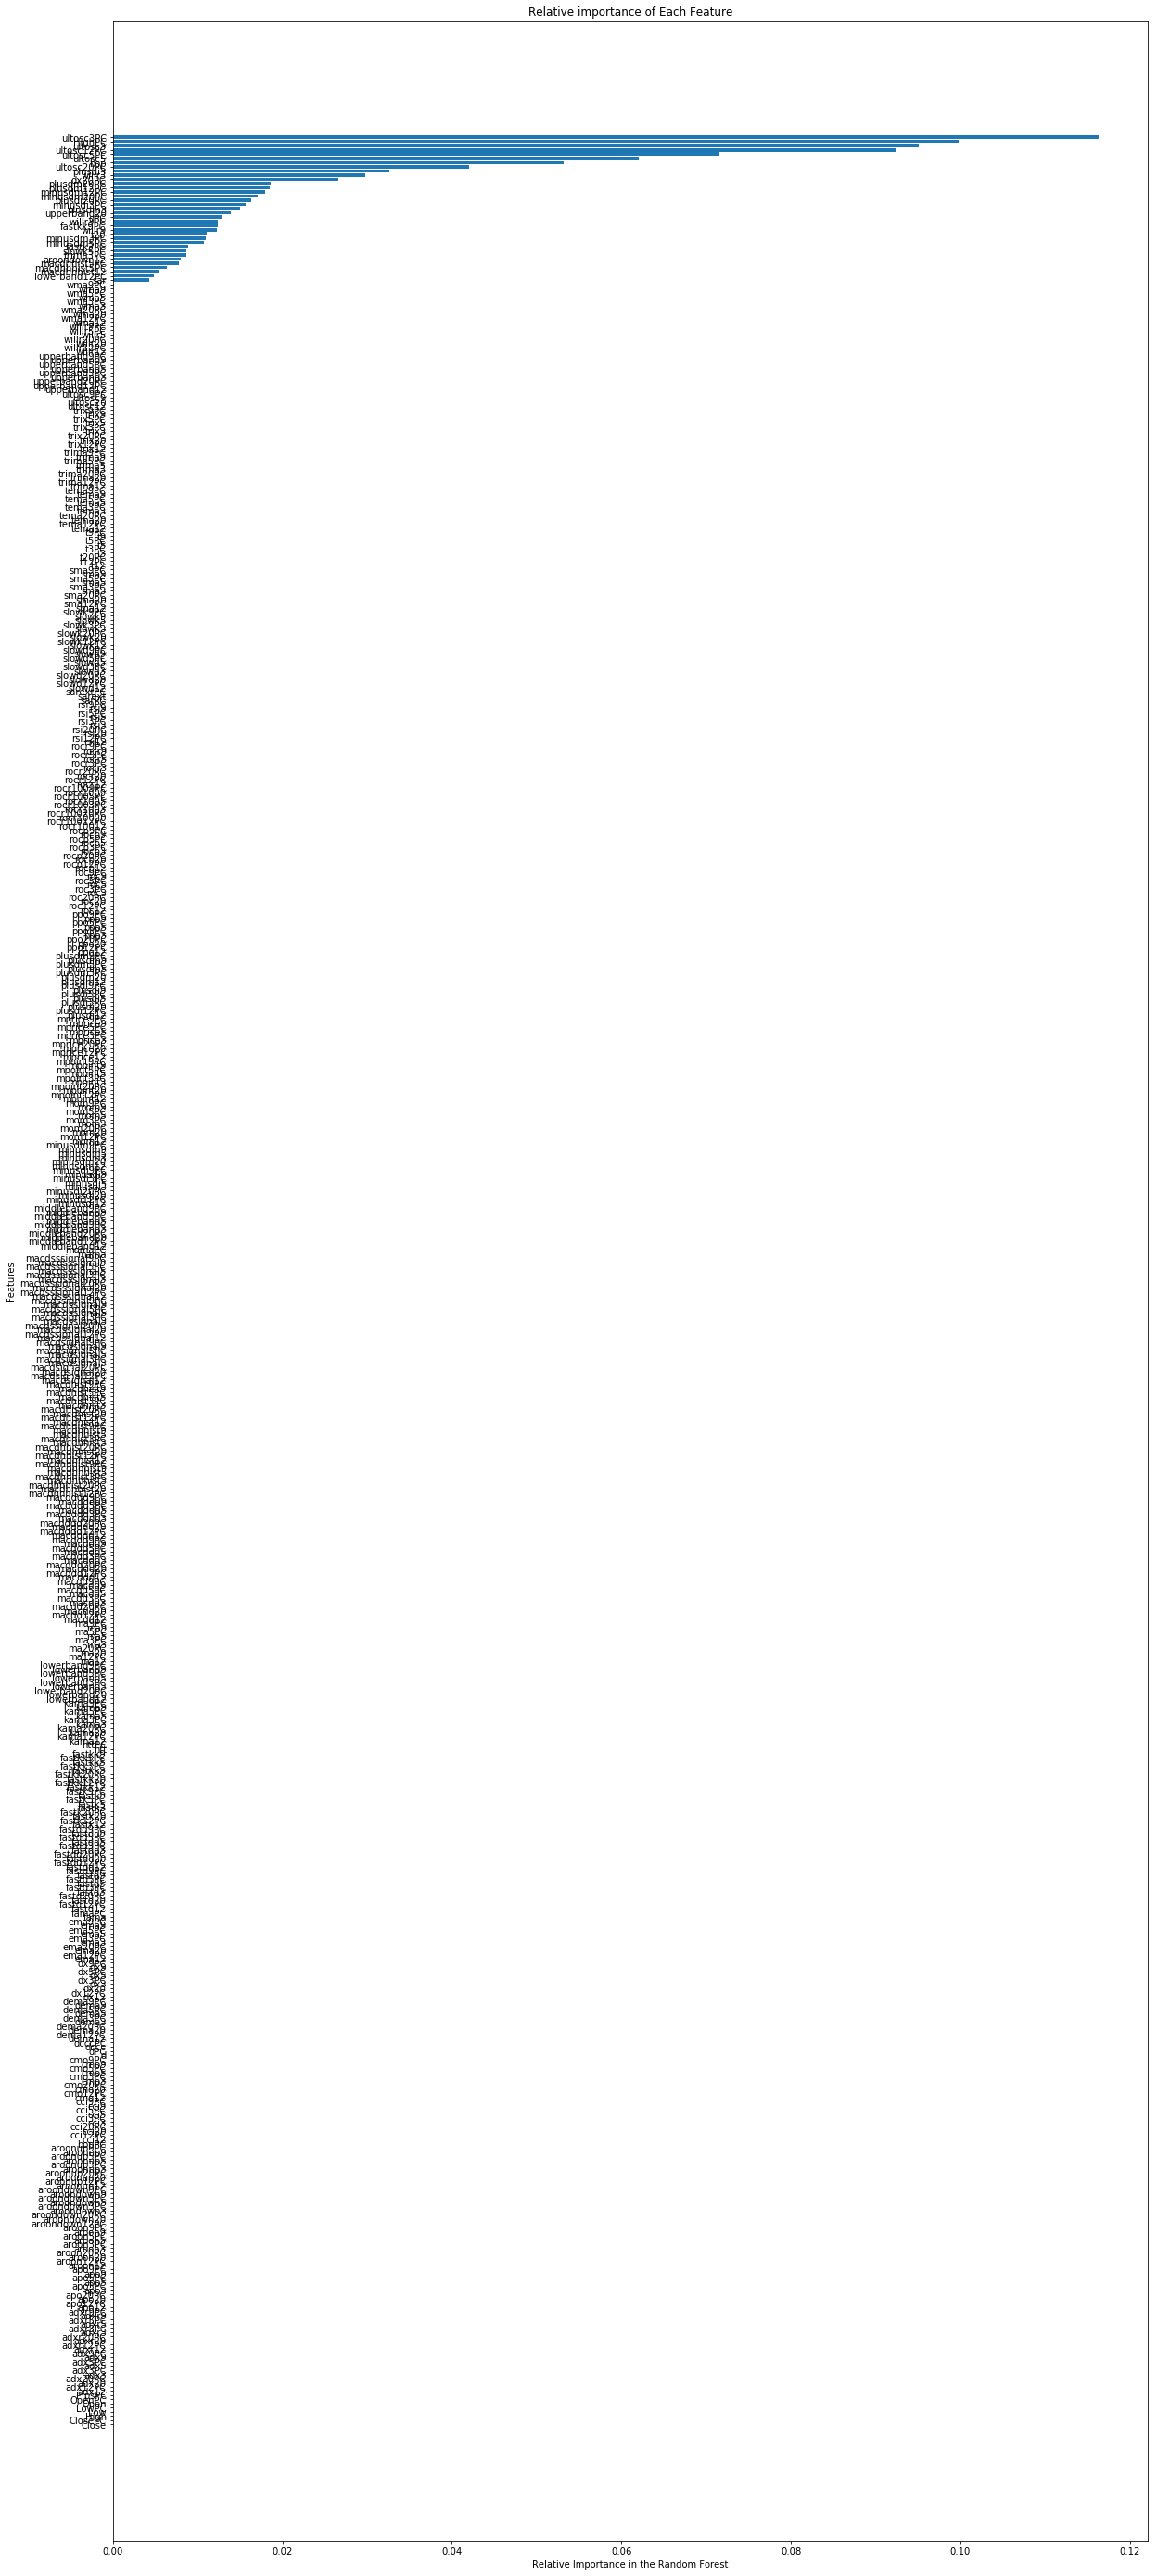

In [191]:
plt.figure(figsize=(20,50))
importance_list = treenames_scores
name_list = treenames
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

In [141]:
#PCA for each class (XN, XT) after selecting 81 features
t1=Xtrain[np.asarray(treenames[0:81])][Ytrain==1]

t0=Xtrain[np.asarray(treenames[0:81])][Ytrain==0]
#t1= StandardScaler().fit_transform(t1)
#t0= StandardScaler().fit_transform(t0)

p1 = PCA().fit(t1)
p0 = PCA().fit(t0)

t11=p1.fit_transform(t1)
t111=pd.DataFrame(t11, index=Xtrain[Ytrain==1].index)

t00=p0.fit_transform(t0)
t000=pd.DataFrame(t00, index=Xtrain[Ytrain==0].index)

XN = pd.concat([t000,t111],ignore_index=False, axis=0)
XN = XN.sort_index()

t1=Xtest[np.asarray(treenames[0:81])][Ytest==1]
t0=Xtest[np.asarray(treenames[0:81])][Ytest==0]

#t1= StandardScaler().fit_transform(t1)
#t0= StandardScaler().fit_transform(t0)

test11=p1.fit_transform(t1)
test111=pd.DataFrame(test11, index=Xtest[Ytest==1].index)

test00=p0.fit_transform(t0)
ttest000=pd.DataFrame(test00, index=Xtest[Ytest==0].index)

XT = pd.concat([ttest000,test111],ignore_index=False, axis=0)
XT = XT.sort_index()

0.983374454811


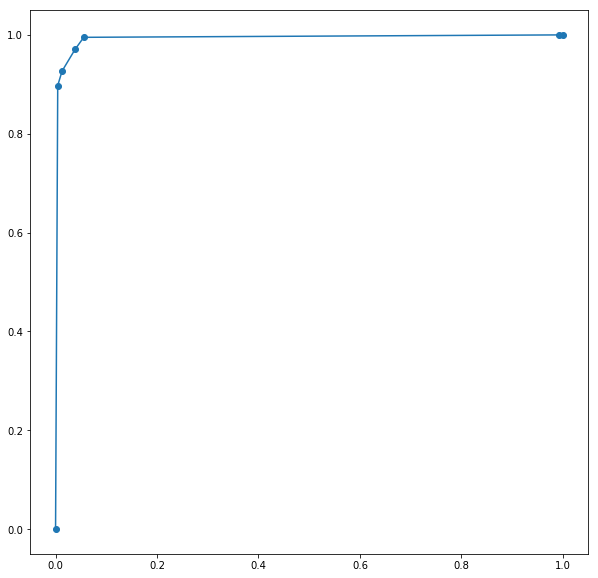

In [145]:
#train on 1st PC and test...VOILA!

c = [0]
GB=GradientBoostingClassifier(n_estimators=1000,verbose=False).fit(XN[c], Ytrain)
print(cross_val_score(cv=5, estimator=GB, X=XN[c], y=Ytrain).mean())

pb=pd.DataFrame(GB.predict_proba(XT[c]))
fpr,tpr,thr = metrics.roc_curve(y_score=pb[1], y_true=Ytest)
plt.figure(figsize=(10,10))
plt.plot(fpr,tpr,"o-")
#for i in range(0,len(thr),8):
    #plt.annotate(thr[i], xy  =(fpr[i],tpr[i]))
plt.show()

In [146]:
print(cross_val_score(cv=5, estimator=GB, X=Xtrain, y=Ytrain).mean())

0.983374454811


In [148]:
GB.score(X=XT[c], y=Ytest)

0.96810933940774491

In [98]:
confusion_matrix(y_pred=GB.predict(X=Xtest), y_true=YYtest)

array([[174,  32],
       [ 80, 153]])

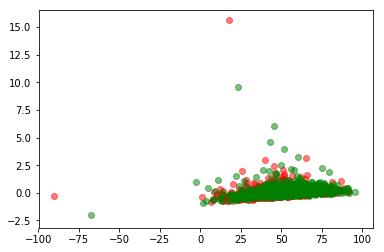

In [1024]:
#['ultosc3PC','ultosc3']
plt.scatter(Xtrain.ultosc3[YYtrain==1], Xtrain.ultosc3PC[YYtrain==1], c='red', alpha=0.5)
plt.scatter(Xtrain.ultosc3[YYtrain==0], Xtrain.ultosc3PC[YYtrain==0], c='green',alpha=0.5)
plt.show()

In [104]:
z = YYtest==hh

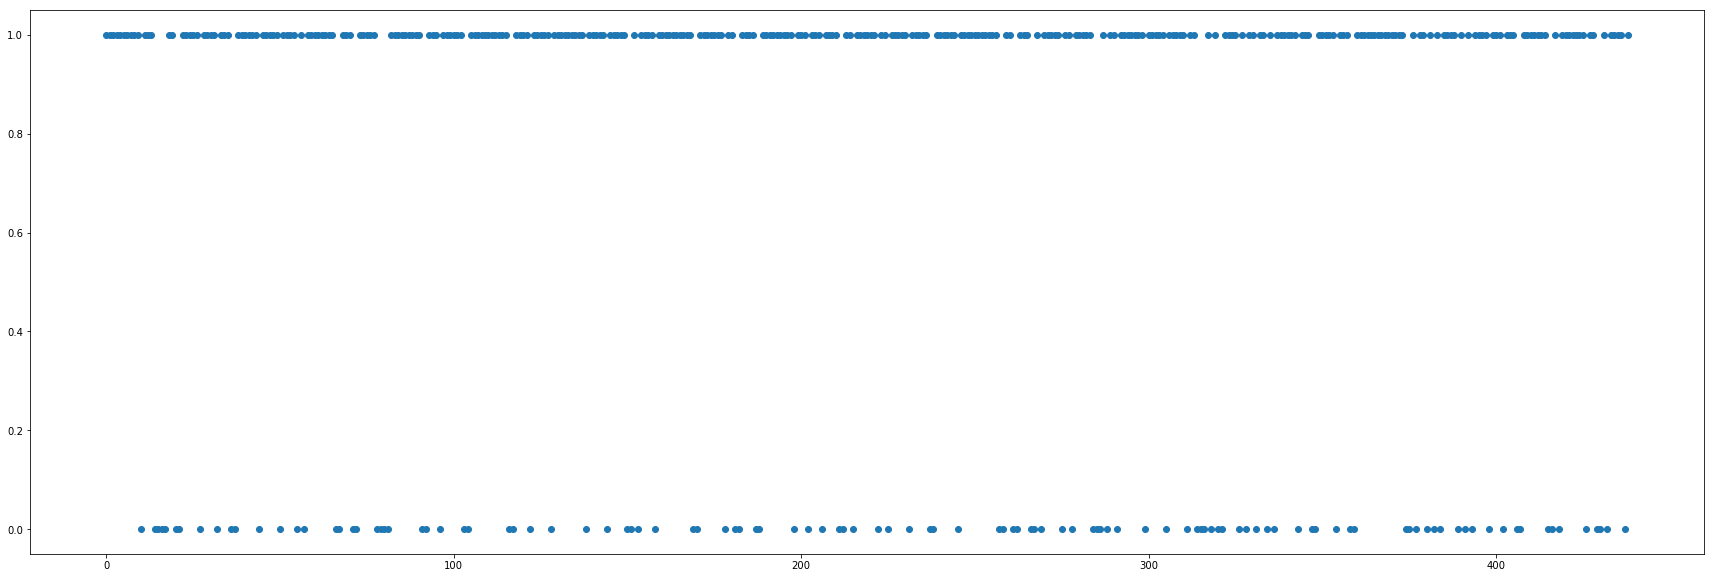

In [108]:
plt.figure(figsize=(30,10))
plt.plot(z,"o")
plt.show()

In [127]:
sum(z[::-100])

3

In [124]:
hh = pd.Series(hh)

In [126]:
hh.sum()

185.0

In [133]:
z.sum()/len(z)

0.74487471526195903

In [138]:
z[len(z)-100:len(z)].mean()

0.72999999999999998

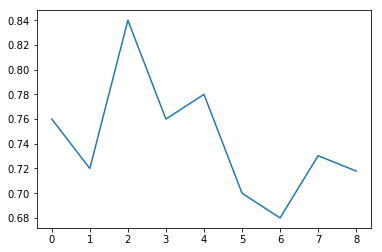

In [174]:
hh=GB.predict(X=Xtest)
z = YYtest==hh

c=[0,50]
xx=[]
for i in list(range(0, len(z), 50)):
    if not c[1]+50 <=len(z):
        c[1]=len(z)
        
    xx.append(z[c[0]:c[1]].mean())
    c[0]=c[0]+50
    c[1]=c[1]+50
        
plt.plot(xx)
plt.show()

In [166]:
c

[350, 400]

In [163]:
z[300:350].mean()

0.68000000000000005

In [164]:
list(range(0, len(z), 50))

[0, 50, 100, 150, 200, 250, 300, 350, 400]

In [167]:
len(z)

439

In [259]:
#get best features
#c=nn[tt>0]
tsco=[]
cssco=[]
tesco=[]
for i in list(range(300, len(Xtrain)+244,300)):
    
    if i > len(Xtrain):
        i=len(Xtrain)
    GB=GradientBoostingClassifier(n_estimators=600).fit(Xtrain[0:i][c], YYtrain[0:i])
    
    tsco.append(GB.score(X=Xtrain[0:i][c], y=YYtrain[0:i]))    
    cssco.append(cross_val_score(cv=5, estimator=GB, X=Xtrain[0:i][c], y=YYtrain[0:i]).mean())
    tesco.append(GB.score(X=Xtest[c], y=YYtest))    


In [263]:
list(range(300, len(Xtrain)+244,300))

[300, 600, 900, 1200, 1500, 1800]

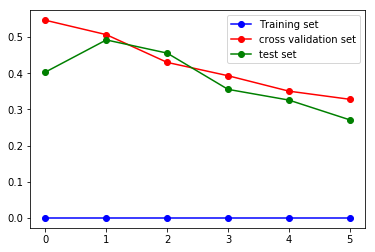

In [292]:
plt.plot(1-pd.Series(tsco), "o-", c="blue", label="Training set")
plt.plot(1-pd.Series(cssco), "o-", c="red", label="cross validation set")
plt.plot(1-pd.Series(tesco), "o-", c="green", label = "test set")
plt.legend()
#plt.xticks(list(range(300, len(Xtrain)+244,300)))
plt.show()

In [279]:
plt.xscale(list(range(300, len(Xtrain)+244,300)))

AttributeError: 'list' object has no attribute 'lower'

In [258]:
cssco

[]

In [270]:
1-pd.Series(cssco)

0    0.546438
1    0.506667
2    0.429931
3    0.393040
4    0.350423
5    0.327934
dtype: float64

In [280]:
c

0         ultosc3PC
1            HighPC
2           ultosc3
3        ultosc12PC
4         ultosc5PC
5           ultosc5
6               bop
7        ultosc20PC
8           plusdi3
9            willr3
10           dx20PC
11       plusdm20PC
12       plusdm12PC
13      minusdm12PC
14      minusdm20PC
15       plusdi20PC
16       minusdi3PC
17          plusdm3
18      upperband20
19              qPC
20         willr3PC
21        fastkk9PC
22           willr9
23              t20
24       minusdm3PC
25       minusdm5PC
26         fastk3PC
27         slowk5PC
28         trima3PC
29      aroondown12
30     macdhhist5PC
31    macdhhhist5PC
32     macdhhhist12
33    lowerband12PC
34              sar
dtype: object

In [291]:
c.to_csv("params")

In [295]:
vv=GB.estimators_[0]

In [406]:
GB=GradientBoostingClassifier(n_estimators=100, min_samples_leaf=300, max_depth=1).fit(Xtrain[c], YYtrain)

In [402]:
GB.get_params

<bound method BaseEstimator.get_params of GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=200,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)>

In [407]:
GB.score(Xtrain[c], YYtrain)

0.71043577981651373

In [408]:
GB.score(Xtest[c], YYtest)

0.74943052391799547

In [409]:
cross_val_score(cv=7, estimator=GB, X=Xtrain[c], y=YYtrain).mean()

0.67899254159495126

In [411]:
tpp=pd.DataFrame(GB.predict_proba(Xtest[c]))

In [436]:
xx=pd.concat([YYtest[tpp[1]>0.5],pd.DataFrame(tpp[1][tpp[1]>0.5])], axis=1)
xx=xx.reset_index(drop=True)
#YYtrain[tpp[1].v>0.5]

In [440]:
tp=xx[xx[0]==1][1]

In [449]:
xx[(xx[0]==0) & (tpp[1][tpp[1]>0.5])][1].count()

/home/shady/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


21

In [457]:
ones=[]
zeroes=[]
for i in list(range(10,100, 10)):
    zeroes.append(xx[(xx[0]==0) & (tpp[1][tpp[1]>i*0.01])][1].count())
    ones.append(xx[(xx[0]==1) & (tpp[1][tpp[1]>i*0.01])][1].count())

/home/shady/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/shady/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [458]:
ones=[]
zeroes=[]
for i in list(range(10,100, 10)):
    if i<=50:
        YYtest[(YYtest==0) & (tpp[1]>]
        
    zeroes.append(xx[(xx[0]==0) & (tpp[1][tpp[1]>i*0.01])][1].count())
    ones.append(xx[(xx[0]==1) & (tpp[1][tpp[1]>i*0.01])][1].count())

[44, 37, 31, 24, 21, 17, 10, 5, 1]

In [479]:
tpp

,0,1
0,0.142810,0.857190
1,0.293761,0.706239
2,0.355955,0.644045
3,0.673361,0.326639
4,0.862916,0.137084
5,0.470440,0.529560
6,0.111937,0.888063
7,0.453213,0.546787
8,0.661536,0.338464
9,0.774023,0.225977


In [522]:
(np.exp(0.2*0.9))-1

0.19721736312181015

In [549]:
[1-(0.5*np.exp(0.3*(i*10)-1)) for i in list([0.1,0.2,0.3,0.4,0.5])]

[0.75170734810429529,
 0.66483997698218034,
 0.54758129098202024,
 0.38929862091991507,
 0.1756393646499359]

In [570]:
[(0.7*np.exp(1*(i))-1) for i in list([0.5,0.6,0.7,0.8,0.9,1])]

[0.1541048894900896,
 0.27548316027335606,
 0.4096268952293336,
 0.55787864994472747,
 0.72172217780986481,
 0.90279727992133152]

In [535]:
0.1*100

10.0

In [552]:
YYtest.mean()

0.530751708428246

In [571]:
GB.predict_proba(Xtest[c])[0][0]

0.14281024558317512

In [572]:
whos

Variable                     Type                          Data/Info
--------------------------------------------------------------------
AdaBoostClassifier           ABCMeta                       <class 'sklearn.ensemble.<...>ting.AdaBoostClassifier'>
BeautifulSoup                type                          <class 'bs4.BeautifulSoup'>
DecisionTreeClassifier       ABCMeta                       <class 'sklearn.tree.tree<...>.DecisionTreeClassifier'>
GB                           GradientBoostingClassifier    GradientBoostingClassifie<...>bose=0, warm_start=False)
GradientBoostingClassifier   ABCMeta                       <class 'sklearn.ensemble.<...>dientBoostingClassifier'>
GridSearchCV                 ABCMeta                       <class 'sklearn.grid_search.GridSearchCV'>
LinearRegression             ABCMeta                       <class 'sklearn.linear_mo<...>l.base.LinearRegression'>
LogisticRegression           type                          <class 'sklearn.linear_mo<...>stic.Logi

In [575]:
%store nn
%store Xtrain
%store Ytrain
%store YYtrain
%store Xtest
%store YYtest
%store Ytest

Stored 'nn' (Series)
Stored 'Xtrain' (DataFrame)
Stored 'Ytrain' (Series)
Stored 'YYtrain' (Series)
Stored 'Xtest' (DataFrame)
Stored 'YYtest' (Series)
Stored 'Ytest' (Series)


In [2]:
%store -r Xtrain

In [4]:
Xtrain.shape

(1744, 546)

In [5]:
%store -r nn
%store -r Xtrain
%store -r Ytrain
%store -r YYtrain
%store -r Xtest
%store -r YYtest
%store -r Ytest

In [14]:
#Xtrain2 = StandardScaler().fit_transform(Xtrain)
Xtest2 = StandardScaler().fit_transform(Xtest)

In [18]:
Xtrain2= pd.DataFrame(Xtrain2)
Xtest2= pd.DataFrame(Xtest2)
Xtrain2.columns= Xtrain.columns
Xtest2.columns = Xtest.columns

In [32]:
hh= GradientBoostingClassifier(n_estimators=100, min_samples_leaf=300, max_depth=1).fit(Xtrain[nn], YYtrain)

In [33]:
hh.score(Xtrain[nn], YYtrain)

0.71043577981651373

In [34]:
hh.score(Xtest[nn], YYtest)

0.74943052391799547